# CM4126 Coursework </p>


s.grant9@rgu.ac.uk<br>
Scott Grant <br>
1705151



# 1. Introduction

# 2. Research and Data Exploration

## 2.1 Research

Peer Reviewed Paper


*   Impact Factor greater or equal to 4.0
*   Dated after 2018
*   Appeared in a journal
*   500 Words



[Deep convolutional neural network based medical image classification for disease diagnosis](https://link.springer.com/article/10.1186/s40537-019-0276-2)


*   Journal 2 Year Impact Factor = 5.095
*   17th December 2019
*   Appeared in 'Journal of Big Data'
*   Used CNN to classify chest X-rays for pneumonia diagnosis

<br>**Compares three methods:**
*   SVM with ORB features
*   Transfer learning of VGG16 and InceptionV3
*   Capsule Network trained from scratch

<br> **Datasets:**
*   [Labeled Optical Coherence Tomography (OCT) and Chest X-Ray Images for Classification](https://data.mendeley.com/datasets/rscbjbr9sj/2)
*   Dataset of 5856 Chest X-rays
*   Labeled as either normal or pneumonia
*   Also uses best model on a dataset of 100k+ optical coherence tomography (OCT) images for eye disease diagnosis

<br>**Results:**
*   Finds VGG16 with one retrained convolutional layer acheives best accuracy of 94.8% on pneumonia dataset
*   Beating the 'state-of-the-art' best result of 93.2%

Don't have to beat paper results
He is mostly concerned about apprach not results
structure, story, methods
Read paper and understand how people report on their work and results




## 2.2 Data Exploration


### 2.2.1 Loading the Data
The code in this section is taken from Lab 05

In [ ]:
# import the required libraries
import os
import zipfile
from skimage import exposure
import numpy as np
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, AveragePooling2D,Flatten, Dense, Conv2D,MaxPool2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

Import file from google drive <br>

The below code was added to the end of the unzip commands as it supresses code output to shorten notebook. Taken from Generative AI
```
> /dev/null 2>&1
```



In [ ]:
#from google.colab import drive
#drive.mount('/content/gdrive')
#!unzip -u "/content/gdrive/MyDrive/4th Year Uni/CM4126/Coursework/ChestXRay2017.zip" -d "/content/" > /dev/null 2>&1

Import file when drive already mounted

In [ ]:
#Use this if mounted using gui (drive button in files tab)
!unzip -u "/content/drive/MyDrive/4th Year Uni/CM4126/Coursework/ChestXRay2017.zip" -d "/content/" > /dev/null 2>&1

In [ ]:
# check the folders in gdrive
!ls /content/ChestXRay2017/

chest_xray


In [ ]:
# data stored in the local drive
main_dirction_path = "/content/ChestXRay2017/chest_xray"
print(os.listdir(main_dirction_path))

['train', 'test']


In [ ]:
# path for train and test folders
train_folder_path = main_dirction_path + '/train/'
test_folder_path = main_dirction_path + '/test/'

In [ ]:
#Defining Labels
labels = os.listdir(train_folder_path)
labels

['NORMAL', 'PNEUMONIA']

In [ ]:
train_n_path = train_folder_path+'/NORMAL/'
train_p_path = train_folder_path+'/PNEUMONIA/'

test_n_path = test_folder_path+'/NORMAL/'
test_p_path = test_folder_path+'/PNEUMONIA/'

Checking the number of images across both the train and test sets

In [ ]:
print(f'Train Set:\nNumber of normal images is {len(os.listdir(train_n_path))}') #length of normal training images
print(f'Number of postive images is {len(os.listdir(train_p_path))}') #length of pneumonia training images
print(f'Total training images is  {len(os.listdir(train_n_path)) + len(os.listdir(train_p_path))}')

print(f'\nTest Set:\nNumber of normal images is {len(os.listdir(test_n_path))}')
print(f'Number of positive images is {len(os.listdir(test_p_path))}')
print(f'Total training images is {len(os.listdir(test_n_path)) + len(os.listdir(test_p_path))}')
ratio = ((len(os.listdir(test_n_path)) + len(os.listdir(test_p_path)))/(len(os.listdir(train_n_path)) + len(os.listdir(train_p_path))))*100
print(f'That is a {ratio}% split')

Train Set:
Number of normal images is 1349
Number of postive images is 3883
Total training images is  5232

Test Set:
Number of normal images is 234
Number of positive images is 390
Total training images is 624
That is a 11.926605504587156% split


Function to load images, extract the labels and resize them

In [ ]:
img_size = 112 #
def get_training_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                #print(f'resized_arr: {type(resized_arr)}, class_num: {type(class_num)}')
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data, dtype='object')

.DS_Store files need to be removed

In [ ]:
!find . -name ".DS_Store" -print -delete

Split off 20% of the train set into a valadation set

In [ ]:
train = get_training_data(train_folder_path)
temp = np.random.permutation(train) # Shuffle the data
train_size = 0.8 # Sets the split ratio

# Assigns 80% to training array and 20% to validation set
train, val = temp[:(int(train_size*len(temp)))], temp[int(train_size*len(temp)):]

In [ ]:
#Checking train is
#print(train)

Loading Test set

In [ ]:
#Loading test set
test = get_training_data(test_folder_path)

Checking shape of sets

In [ ]:
print(f'The shape of the training set is {train.shape}')
print(f'The shape of the test set is {test.shape}')
print(f'The shape of the val set is {val.shape}')

The shape of the training set is (4185, 2)
The shape of the test set is (624, 2)
The shape of the val set is (1047, 2)


Plotting Distribution

<Axes: xlabel='count'>

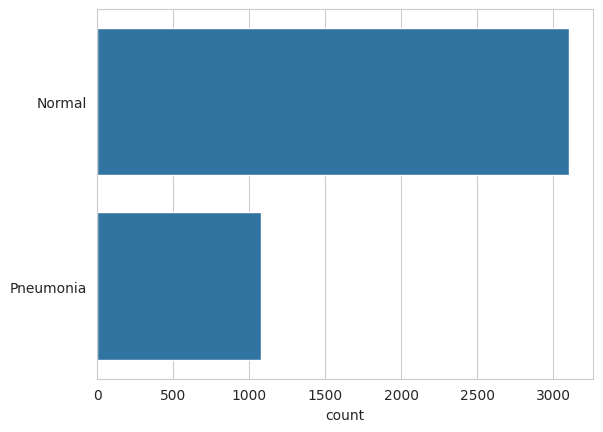

In [ ]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('whitegrid')
sns.countplot(l)

Inspecting samples of both positive and negative images

In [ ]:
def show_sample_images (number, normal=True):
    plt.figure(figsize=(12,12))
    if normal == True:
        for n in range(number):
            normal_img = os.listdir(train_n_path)[n]
            normal_img_address = train_n_path+normal_img
            normal_load = Image.open(normal_img_address)
            ax = plt.subplot(int(number/2),int(number/2),n+1)
            plt.imshow(normal_load, cmap ='gray')
            plt.title("NORMAL")
    else:
        for n in range(number):
            pneumonia_img =  os.listdir(train_p_path)[n]
            pneumonia_img_address = train_p_path+pneumonia_img
            pneumonia_load = Image.open(pneumonia_img_address)
            #cast nrows to integer
            ax = plt.subplot(int(number/2),int(number/2),n+1)
            plt.imshow(pneumonia_load, cmap ='gray')
            plt.title("PNEUMONIA")

    plt.axis("off")

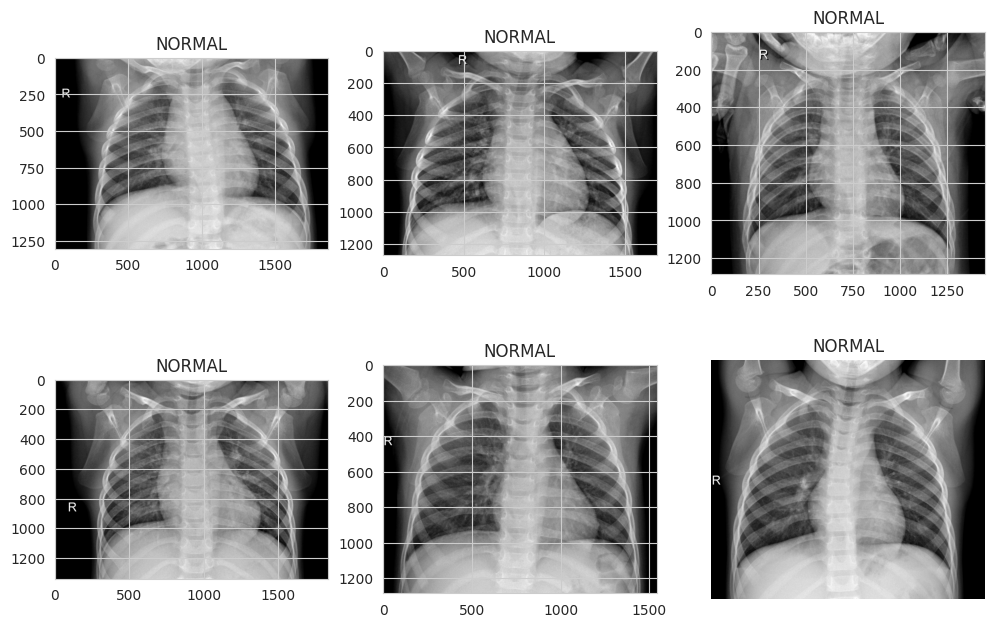

In [ ]:
# Show normal images
numberImg= 6
show_sample_images(numberImg)

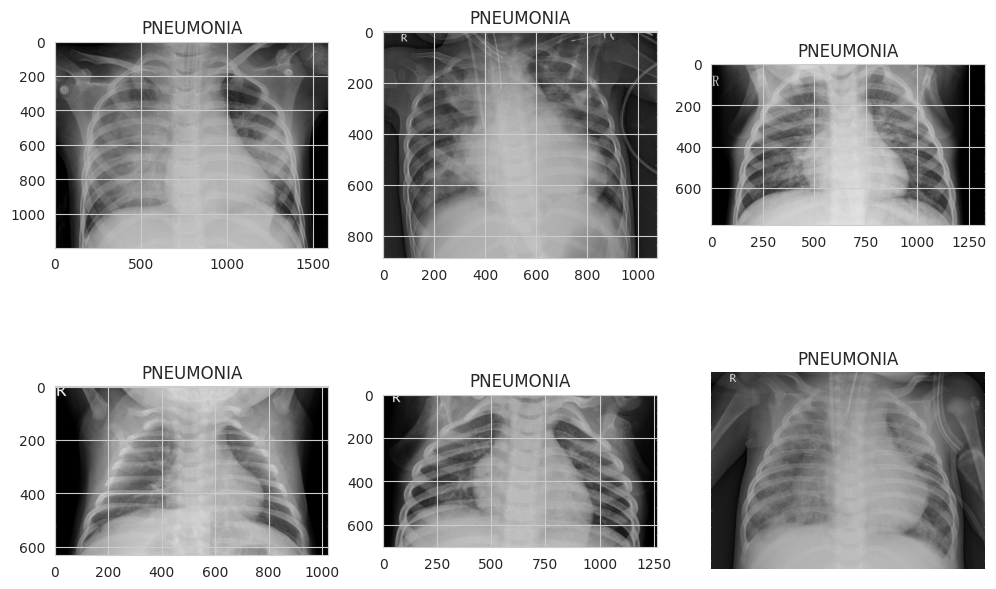

In [ ]:
# show pneumonia images
show_sample_images(6,False)

### 2.2.2 Pre-Processing the Data

By applying histogram, this improves contrast of the image giving a better visualisation. This is code taken from Lab 05

In [ ]:
def equlize_hist_ (image):
  _image = np.asarray(image)
  image_eq = exposure.equalize_hist(_image)
  return image_eq

In [ ]:
def expose_image(Normal=True):
    if Normal==True:
        # Choose normal random image: generate random number between 1 and  the number of normal images in the training set
        random_img_ind= np.random.randint(0,len(os.listdir(train_n_path)))
        # image file name
        img_expose_name = os.listdir(train_n_path)[random_img_ind]

        # path to the image
        img_expose_address = train_n_path+img_expose_name

        # load mage
        img_expose = Image.open(img_expose_address)
        img = np.asarray(img_expose)
        image_eq = equlize_hist_(img)
        figure1 = plt.figure(figsize= (16,16))
        img_1 = figure1.add_subplot(1,2,1)
        img_plot = plt.imshow(img, cmap = 'gray')
        img_1.set_title('Normal')
        plt.axis("off")

        img2 = figure1.add_subplot(1, 2, 2)
        img_plot = plt.imshow(image_eq, cmap = 'gray')
        img2.set_title('Normal after HE')
        plt.axis("off")
    else:
        # Choose normal random image: generate random number between 1 and  the number of normal images in the training set
        random_img_ind= np.random.randint(0,len(os.listdir(train_p_path)))
        # image file name
        img_expose_name = os.listdir(train_p_path)[random_img_ind]

        # path to the image
        img_expose_address = train_p_path+img_expose_name

        # load mage
        img_expose = Image.open(img_expose_address)
        img = np.asarray(img_expose)
        image_eq = equlize_hist_(img)
        figure1 = plt.figure(figsize= (16,16))
        img_1 = figure1.add_subplot(1,2,1)
        img_plot = plt.imshow(img, cmap = 'gray')
        img_1.set_title('Pneumonia')
        plt.axis("off")

        img2 = figure1.add_subplot(1, 2, 2)
        img_plot = plt.imshow(image_eq, cmap = 'gray')
        img2.set_title('Pneumonia after HE')
        plt.axis("off")

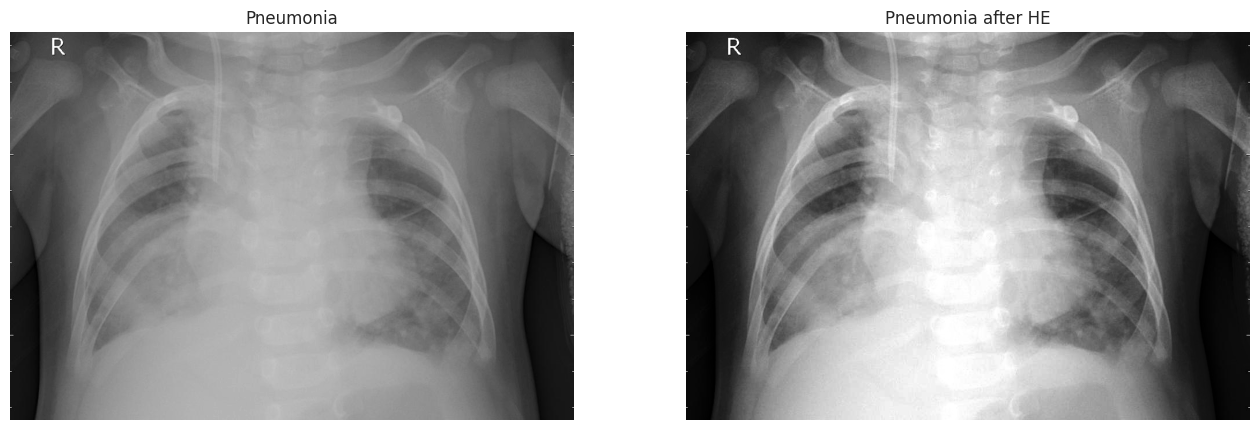

In [ ]:
# expose_image() will show random normal image
expose_image(False)

### 2.2.3 Splitting the Data

In [ ]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)

for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [ ]:
print(f'Number of images in the training set is {len(x_train)}')

Number of images in the training set is 4185


Normalising data

In [ ]:
x_train = np.array(x_train) / 255.0
x_val = np.array(x_val) / 255.0
x_test = np.array(x_test) / 255.0

In [ ]:
before_size = len(x_train)

Resizing arrays for the deep learning

In [ ]:
x_train = x_train.reshape(-1, img_size, img_size, 3)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 3)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 3)
y_test = np.array(y_test)

Applying Data Augmentation to improve the model's performance by generating more training data for it

In [ ]:
datagen = ImageDataGenerator(
      featurewise_center=False,
      samplewise_center=False,
      featurewise_std_normalization=False,
      samplewise_std_normalization=False,
      zca_whitening=False,
      rotation_range = 30,
      zoom_range = 0.2,

      width_shift_range = 0.1,
      height_shift_range = 0.1,
      horizontal_flip = True,
      vertical_flip=False)
datagen.fit(x_train)

# 3. Baseline Model


## 3.1 Creating the model

In [ ]:
# Model setup
model = Sequential()
model.add(Conv2D(32, (3,3), strides = 1, padding = 'same', activation = 'relu', input_shape = (img_size, img_size, 3)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides = 2, padding = 'same'))
model.add(Conv2D(64, (3,3), strides = 1, padding = 'same', activation = 'relu', input_shape = (img_size, img_size, 3)))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides = 2, padding = 'same'))
model.add(Conv2D(64, (3,3), strides = 1, padding = 'same', activation = 'relu', input_shape = (img_size, img_size, 3)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides = 2, padding = 'same'))
model.add(Conv2D(128, (3,3), strides = 1, padding = 'same', activation = 'relu', input_shape = (img_size, img_size, 3)))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides = 2, padding = 'same'))
model.add(Conv2D(256, (3,3), strides = 1, padding = 'same', activation = 'relu', input_shape = (img_size, img_size, 3)))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides = 2, padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1, activation = 'sigmoid'))

model.compile(
              optimizer = 'rmsprop', loss = 'binary_crossentropy',
              metrics = ['accuracy']
              )

In [ ]:
# model summary (see the number of trainable parameters)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 112, 112, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 112, 112, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 56, 56, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 56, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 56, 56, 64)        0         
                                                                 
 batch_normalization_1 (Bat  (None, 56, 56, 64)        2

In [ ]:
total = len(os.listdir(train_n_path)) + len(os.listdir(train_p_path))
neg = len(os.listdir(train_n_path))
pos = len(os.listdir(train_p_path))

weight_for_0 = 1 /neg * (total/2.0)
weight_for_1 = 1/pos *(total/2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}
class_weight

{0: 1.939214232765011, 1: 0.6737058975019315}

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy', patience = 2, verbose = 1, factor = 0.3, min_lr = 0.000001)

In [ ]:
img_size = 112 #
batch_size = 16
n_epochs = 25

In [ ]:
# Start training the model
history = model.fit(datagen.flow(x_train, y_train, batch_size = batch_size),
                    epochs = n_epochs, validation_data = datagen.flow(x_val, y_val),
                    callbacks = [learning_rate_reduction], class_weight = class_weight)

Epoch 1/25
262/262 [==============================] - 28s 77ms/step - loss: 0.5852 - accuracy: 0.7959 - val_loss: 30.6605 - val_accuracy: 0.7421 - lr: 0.0010
Epoch 2/25
262/262 [==============================] - 18s 68ms/step - loss: 0.3971 - accuracy: 0.8588 - val_loss: 2.6482 - val_accuracy: 0.7631 - lr: 0.0010
Epoch 3/25
262/262 [==============================] - 19s 74ms/step - loss: 0.2985 - accuracy: 0.8908 - val_loss: 0.3275 - val_accuracy: 0.8682 - lr: 0.0010
Epoch 4/25
262/262 [==============================] - 20s 77ms/step - loss: 0.2766 - accuracy: 0.8970 - val_loss: 31.4392 - val_accuracy: 0.7421 - lr: 0.0010
Epoch 5/25
262/262 [==============================] - ETA: 0s - loss: 0.2424 - accuracy: 0.9073
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
262/262 [==============================] - 19s 72ms/step - loss: 0.2424 - accuracy: 0.9073 - val_loss: 0.4837 - val_accuracy: 0.7889 - lr: 0.0010
Epoch 6/25
262/262 [==============================] 

## 3.2 Checking model results

<Axes: >

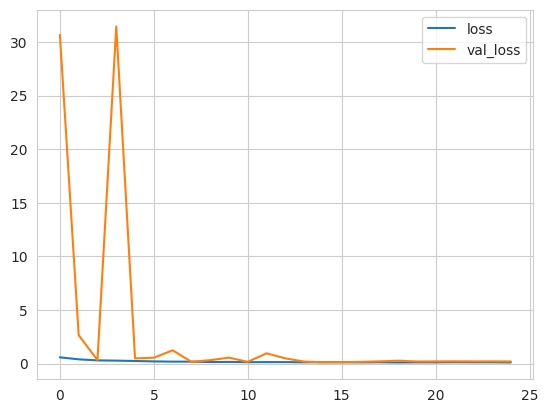

In [ ]:
losses = pd.DataFrame(model.history.history)
losses[['loss','val_loss']].plot()

<Axes: >

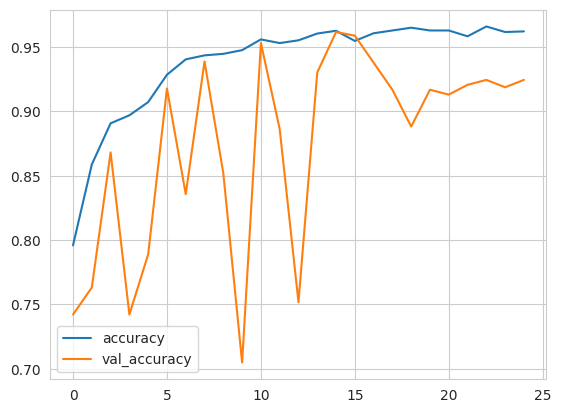

In [ ]:
losses[['accuracy','val_accuracy']].plot()

Checking accuracy/loss

In [ ]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 0s 9ms/step - loss: 0.3384 - accuracy: 0.8766
Loss of the model is -  0.3383718729019165
20/20 [==============================] - 0s 8ms/step - loss: 0.3384 - accuracy: 0.8766
Accuracy of the model is -  87.66025900840759 %


Saving the model

In [ ]:
from tensorflow.keras.models import load_model
model.save('CNN_PNEUMONIA.h5') #
cnn_model = load_model("./CNN_PNEUMONIA.h5")
predictions=model.predict(x_test)
pred_labels= np.where(predictions>0.5, 1, 0)

20/20 [==============================] - 0s 7ms/step


# 4. Solution Improvement (Transfer learning)

# 5. Conclusion and Future Improvement